In [15]:
import os
import scanpy as sc
import bin2cell as b2c
import matplotlib.pyplot as plt
import gc

In [3]:
### parameters to be input
SAMPLE_NAME = 'G1'
lib_id = SAMPLE_NAME # list(sp_adata.uns['spatial'].keys())[0]

path = os.path.expanduser("~")+"/Desktop/space/GCTB_bin2cell"
save_path_for_today = "outputs/250610_" + SAMPLE_NAME
source_image_path = "../VisiumHD/image/microscope_image/" + SAMPLE_NAME + ".tif"
expression_path = "../VisiumHD/spaceranger/" + SAMPLE_NAME + "/outs/binned_outputs/square_002um"
### optional 8/16 um binned dataset
expression_path_8um = "../VisiumHD/spaceranger/" + SAMPLE_NAME + "/outs/binned_outputs/square_008um"
expression_path_16um = "../VisiumHD/spaceranger/" + SAMPLE_NAME + "/outs/binned_outputs/square_016um"
###

# setting for stardist nuclei annotation in bin2cell
mpp = 0.5
prob_thresh_HE = 0.05
prob_thresh_GEX = 0.25
nms_thresh = 0.5
max_bin_distance=2 # default = 2

# area to be analyzed
# ## GCTB spatial G1, FFPE9
mask_small_x1, mask_small_x2, mask_small_y1, mask_small_y2 = 1450, 1750, 250, 550
mask_large_x1, mask_large_x2, mask_large_y1, mask_large_y2 = 450, 1950, 250, 1750


In [4]:
# setting for filenames
HE_filename = "he.tiff"
HE_label_filename = "he_labels.pdf"
npz_filename = "he.npz"
label_image_filename = "he_labels_image.pdf"
gex_filename = "gex.tiff"
gex_npz_filename = "gex.npz"
gex_labels_filename = "gex_labels.pdf"
gex_npz_dummy_filename = "gex_dummy.npz"
gex_label_image_filename = "gex_label.tiff"
gex_label_pdf_filename_pdf = "gex_labels_image.pdf"
h5ad_filename = SAMPLE_NAME + "_b2c.h5ad"
calib_filename = "spatial_destriping.pdf"
h5ad_full_filename = SAMPLE_NAME + "_2um.h5ad"
h5ad_predicted_full_filename = SAMPLE_NAME + "_nucleus_predicted.h5ad"
h5ad_sc_filtered_full_filename = SAMPLE_NAME + "_single_cell_filtered.h5ad"
h5ad_sc_microenvironment_full_filename = SAMPLE_NAME + "_single_cell_microenvironment.h5ad"
csv_filename = "expression_subset_with_object_id.csv"
save_spatial_plot_path = os.path.join(save_path_for_today, "cropped_spatial_plot.svg")
save_svg_path = os.path.join(save_path_for_today, "spatial_salvage_labels.svg")
celltype_filename = SAMPLE_NAME + "_overlay_hires_by_celltype.pdf"
celltypist_model_filename = "model_GCT.pkl"
calib_full_path = os.path.join(save_path_for_today, calib_filename)
h5ad_save_path = os.path.join(save_path_for_today, h5ad_filename)
h5ad_full_save_path = os.path.join(save_path_for_today, h5ad_full_filename)
h5ad_predicted_full_save_path = os.path.join(save_path_for_today, h5ad_predicted_full_filename)
h5ad_sc_filtered_full_save_path = os.path.join(save_path_for_today, h5ad_sc_filtered_full_filename)
h5ad_microenvironment_full_save_path = os.path.join(save_path_for_today, h5ad_sc_microenvironment_full_filename)
csv_save_path = os.path.join(save_path_for_today, csv_filename)
gex_label_pdf_full_path_pdf = os.path.join(save_path_for_today, gex_label_pdf_filename_pdf)
gex_label_full_path = os.path.join(save_path_for_today, gex_label_image_filename)
gex_npz_dummy_full_path = os.path.join(save_path_for_today, gex_npz_dummy_filename)
gex_labels_full_path = os.path.join(save_path_for_today, gex_labels_filename)
gex_full_path = os.path.join(save_path_for_today, gex_filename)
gex_labels_path = os.path.join(save_path_for_today, gex_npz_filename)
gex_label_image_full_path = os.path.join(save_path_for_today, gex_label_image_filename)
label_image_full_path = os.path.join(save_path_for_today, label_image_filename)
labels_path = os.path.join(save_path_for_today, npz_filename)
HE_full_path = os.path.join(save_path_for_today, HE_filename)
HE_label_full_path = os.path.join(save_path_for_today, HE_label_filename)
celltype_out_pdf = os.path.join(save_path_for_today, celltype_filename)

os.chdir(path)
os.makedirs(save_path_for_today, exist_ok=True)


# Nuclei segmentation with bin2cell

anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Cropped spatial coordinates key: spatial_cropped_150_buffer
Image key: 0.5_mpp_150_buffer


_construct.py (163): Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2152441789.py (15): Use `squidpy.pl.spatial_scatter` instead.
anndata.py (1138): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1138): Trying to modify attribute `.var` of view, initializing view as actual.


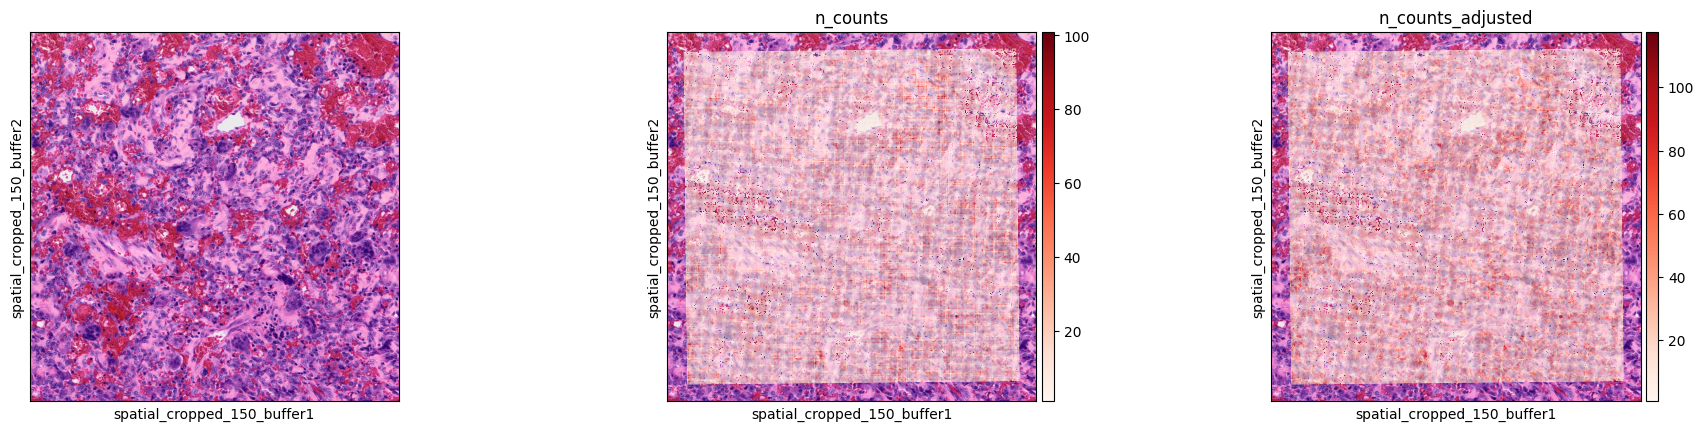

In [8]:
sp_adata = b2c.read_visium(expression_path, source_image_path = source_image_path)
sp_adata.var_names_make_unique()
sc.pp.filter_genes(sp_adata, min_cells=3)
sc.pp.filter_cells(sp_adata, min_counts=1)
b2c.scaled_he_image(sp_adata, mpp=mpp, save_path=HE_full_path)
b2c.destripe(sp_adata,adjust_counts=True) # integer -> float

#define a mask to easily pull out this region of the object in the future
mask = ((sp_adata.obs['array_row'] >= mask_small_x1) & 
        (sp_adata.obs['array_row'] <= mask_small_x2) & 
        (sp_adata.obs['array_col'] >= mask_small_y1) & 
        (sp_adata.obs['array_col'] <= mask_small_y2)
       )
bdata = sp_adata[mask]
sc.pl.spatial(bdata, color=[None, "n_counts", "n_counts_adjusted"], img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer",show=True,cmap='Reds')
# plt.savefig(calib_full_path, bbox_inches="tight") # to save figure as pdf
# plt.close()
del bdata

Found model '2D_versatile_he' for 'StarDist2D'.


I0000 00:00:1749886163.932962 50465499 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1749886163.932983 50465499 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|███████████████████████████████████████████| 16/16 [02:02<00:00,  7.63s/it]


Found 241108 objects


2577826428.py (17): Trying to modify attribute `.obs` of view, initializing view as actual.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1189427301287651..1.0044052600860596].


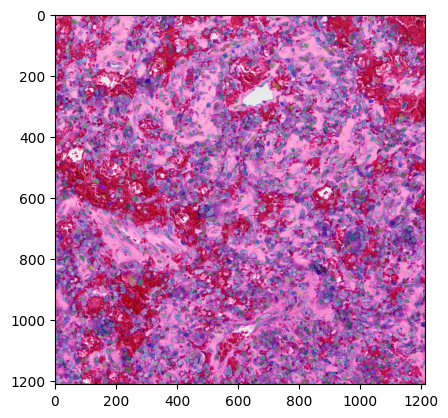

In [10]:
# Nuclei annotation, takes a few minutes
b2c.stardist(image_path=HE_full_path, 
             labels_npz_path=labels_path, 
             stardist_model="2D_versatile_he", 
             prob_thresh=prob_thresh_HE
            )
b2c.insert_labels(sp_adata, 
                  labels_npz_path=labels_path, 
                  basis="spatial", 
                  spatial_key="spatial_cropped_150_buffer",
                  mpp=mpp, 
                  labels_key="labels_he"
                 )
#0 means unassigned
bdata = sp_adata[mask]
bdata = bdata[bdata.obs['labels_he']>0]
bdata.obs['labels_he'] = bdata.obs['labels_he'].astype(str)

# sc.pl.spatial(bdata, color=[None, "labels_he"], img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer",legend_loc=None,show=True)
# plt.savefig(HE_label_full_path, bbox_inches="tight") # to save figure as pdf
# plt.close()
crop = b2c.get_crop(bdata, basis="spatial", spatial_key="spatial_cropped_150_buffer", mpp=mpp)
rendered = b2c.view_stardist_labels(image_path=HE_full_path, 
                                    labels_npz_path=labels_path, 
                                    crop=crop
                                   )
plt.imshow(rendered)
# plt.savefig(label_image_full_path, bbox_inches="tight", dpi=300) # to save figure as pdf
del bdata

2458022759.py (10): Trying to modify attribute `.obs` of view, initializing view as actual.
2458022759.py (14): Use `squidpy.pl.spatial_scatter` instead.


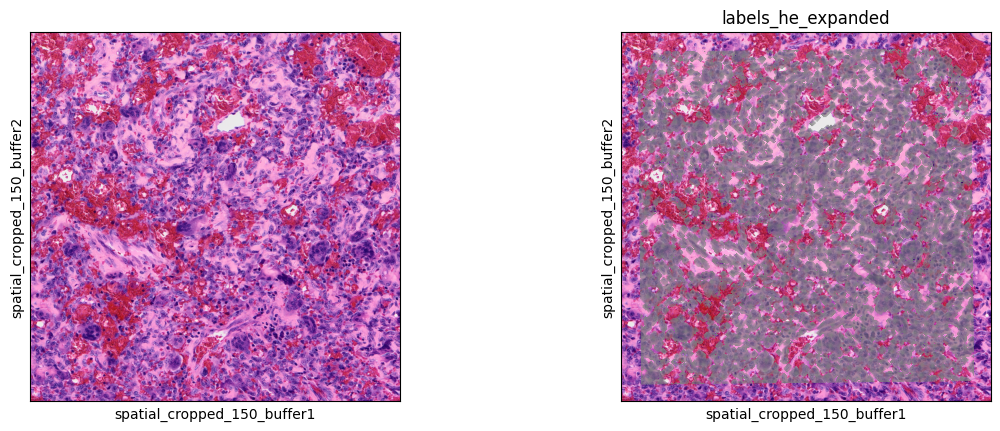

In [11]:
b2c.expand_labels(sp_adata, 
                  labels_key='labels_he', 
                  max_bin_distance=max_bin_distance,
                  expanded_labels_key="labels_he_expanded"
                 )
bdata = sp_adata[mask]

#0 means unassigned
bdata = bdata[bdata.obs['labels_he_expanded']>0]
bdata.obs['labels_he_expanded'] = bdata.obs['labels_he_expanded'].astype(str)

expanded_filename = "spatial_expanded_labels.pdf"
expanded_full_path = os.path.join(save_path_for_today, expanded_filename)
sc.pl.spatial(bdata, color=[None, "labels_he_expanded"], img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer",legend_loc=None,show=True)
# plt.savefig(expanded_full_path, bbox_inches="tight", dpi=300) # to save figure as pdf
# plt.close()
del bdata

In [12]:
# expression based nuclei annotation, takes a few minutes
b2c.grid_image(sp_adata, "n_counts_adjusted", mpp=mpp, sigma=5, save_path=gex_full_path)
b2c.stardist(image_path=gex_full_path, 
             labels_npz_path=gex_labels_path, 
             stardist_model="2D_versatile_fluo", 
             prob_thresh=prob_thresh_GEX, 
             nms_thresh=nms_thresh
            )
b2c.insert_labels(sp_adata, 
                  labels_npz_path=gex_labels_path, 
                  basis="array", 
                  mpp=mpp, 
                  labels_key="labels_gex"
                 )

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|███████████████████████████████████████████| 16/16 [02:09<00:00,  8.12s/it]


Found 83017 objects


588578728.py (5): Trying to modify attribute `.obs` of view, initializing view as actual.
588578728.py (7): Use `squidpy.pl.spatial_scatter` instead.


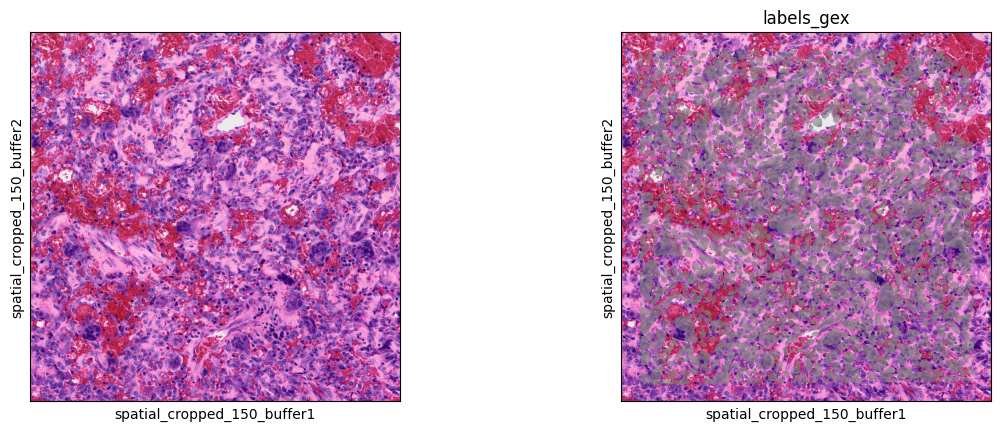

Salvaged 3476 secondary labels


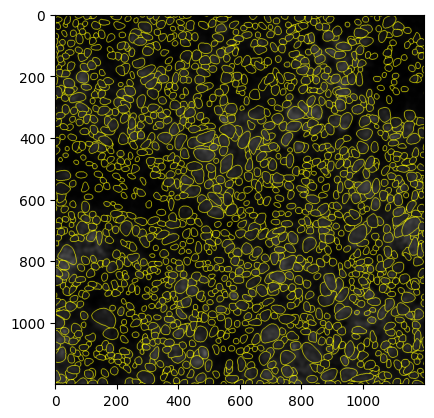

In [13]:
bdata = sp_adata[mask]

#0 means unassigned
bdata = bdata[bdata.obs['labels_gex']>0]
bdata.obs['labels_gex'] = bdata.obs['labels_gex'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_gex"], img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer",legend_loc=None,show=True)
# plt.savefig(gex_label_image_full_path, bbox_inches="tight", dpi=300) # to save figure as pdf
# plt.close()

#the label viewer wants a crop of the processed image
#get the corresponding coordinates spanning the subset object
crop = b2c.get_crop(bdata, basis="array", mpp=mpp)
rendered = b2c.view_labels(image_path=gex_full_path, 
                                    labels_npz_path=gex_labels_path,
                                    crop=crop,
                                   )
plt.imshow(rendered)
# plt.savefig(gex_label_pdf_full_path_pdf, bbox_inches="tight", dpi=300) # to save figure as pdf
b2c.salvage_secondary_labels(sp_adata, 
                             primary_label="labels_he_expanded", 
                             secondary_label="labels_gex", 
                             labels_key="labels_joint"
                            )

405936190.py (5): Trying to modify attribute `.obs` of view, initializing view as actual.
405936190.py (7): Use `squidpy.pl.spatial_scatter` instead.


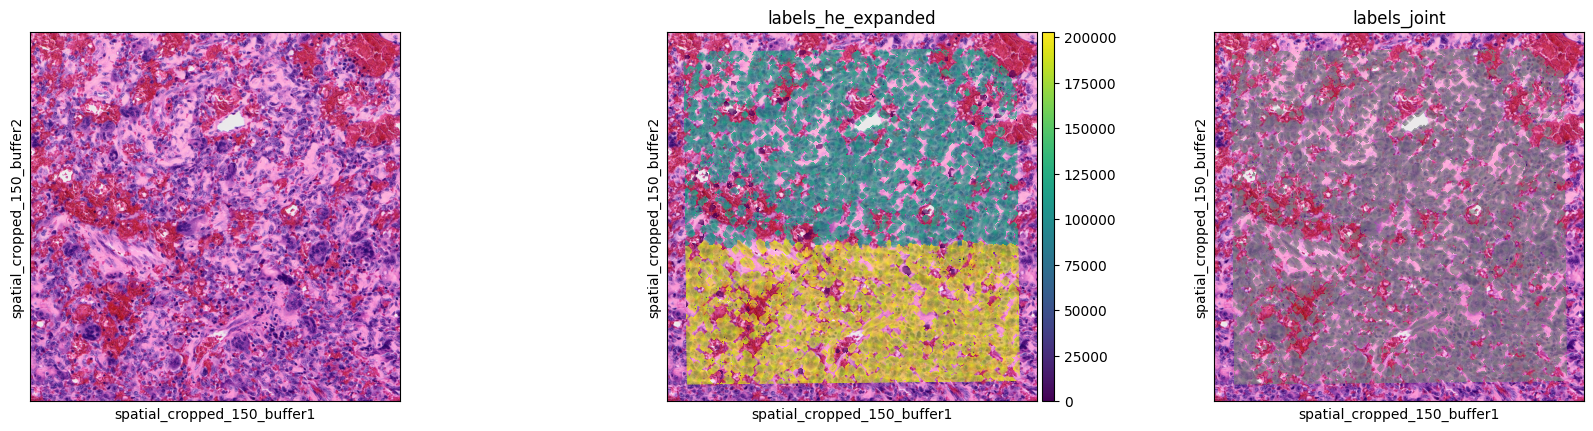

195581

In [16]:
bdata = sp_adata[mask]

#0 means unassigned
bdata = bdata[bdata.obs['labels_joint']>0]
bdata.obs['labels_joint'] = bdata.obs['labels_joint'].astype(str)

sc.pl.spatial(bdata, color=[None,"labels_he_expanded", "labels_joint"], img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer",legend_loc=None,save=True)
# plt.savefig(save_svg_path, bbox_inches='tight', dpi=300)
# plt.close()
del bdata
gc.collect()

### Important selection: nuclei segmentation with or without gene expression data
Note that noise is removed in downstream analysis to set the minimum area (minimum 2um bin number) at which nuclei are recognized. <br> There are often no major problems with the use of gene expression data.

In [17]:
# With gene expression data
cdata = b2c.bin_to_cell(sp_adata, labels_key="labels_joint", spatial_keys=["spatial", "spatial_cropped_150_buffer"])

# Without gene expression data
# cdata = b2c.bin_to_cell(sp_adata, labels_key="labels_he_expanded", spatial_keys=["spatial", "spatial_cropped_150_buffer"])

2711894644.py (9): Use `squidpy.pl.spatial_scatter` instead.
anndata.py (1138): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1138): Trying to modify attribute `.var` of view, initializing view as actual.
anndata.py (1138): Trying to modify attribute `.var` of view, initializing view as actual.


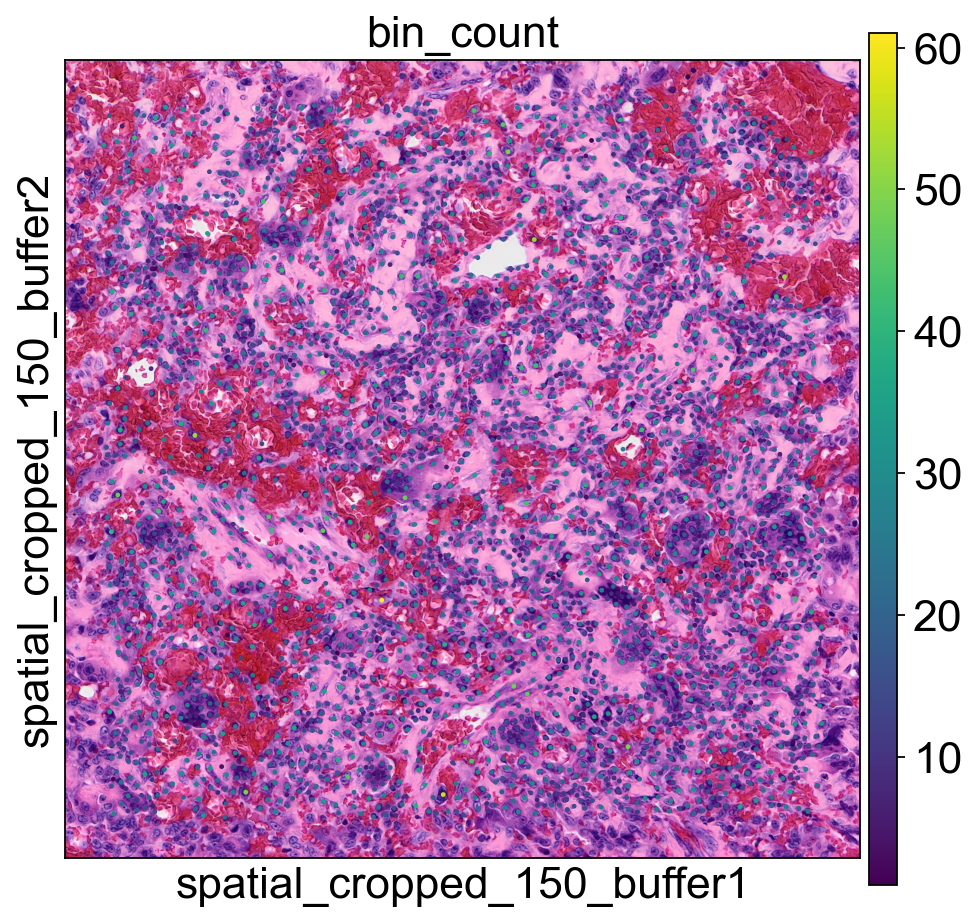

In [18]:
cell_mask = ((cdata.obs['array_row'] >= mask_small_x1) & 
             (cdata.obs['array_row'] <= mask_small_x2) & 
             (cdata.obs['array_col'] >= mask_small_y1) & 
             (cdata.obs['array_col'] <= mask_small_y2)
            )

ddata = cdata[cell_mask]
sc.set_figure_params(fontsize=20,figsize=[7,7])
sc.pl.spatial(ddata, color=["bin_count"], img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer",s=4,save=False)
# plt.savefig(save_spatial_plot_path, bbox_inches="tight", dpi=300) # optional
# plt.close()
del ddata

In [19]:
cdata.write_h5ad(h5ad_save_path)
# sp_adata.write_h5ad(h5ad_full_save_path)# optional
del sp_adata, cdata
gc.collect()

6290251